# Explore the results of the given examples

### Import the required packages and disable some expected warnings

In [1]:
import logging

from morphio import set_ignored_warning
from morphio import Warning
from neurom import load_morphology
from neurom.view import plotly_impl

logging.getLogger("neurots.generate.grower").disabled = True
set_ignored_warning([Warning.zero_diameter], True)

### Run the example extract_synthesis_inputs.py and plot the result

In [ ]:
# Create 100 Neurons from C220197A-P2 https://neuromorpho.org/KeywordResult.jsp?count=1&keywords=%22C220197A-P2%22

In [2]:
import neurots
from neurots import extract_input
import json


def extract_distr_and_param(output_dir, data_dir):
    # Generate distribution from directory of neurons
    distr = extract_input.distributions(
        data_dir / "neurons", feature="path_distances", diameter_model="default"
    )

    # Save distributions in a json file
    with open(output_dir / f"bio612/test_distr.json", "w", encoding="utf-8") as f:
        json.dump(distr, f, sort_keys=True, indent=2)

    # Generate default parameters for topological synthesis of basal dendrites
    params = extract_input.parameters(feature="path_distances", method="tmd")

    # Save parameters in a json file
    with open(output_dir / f"bio612/test_params.json", "w", encoding="utf-8") as f:
        json.dump(params, f, sort_keys=True, indent=2)

In [3]:
# extract_synthesis_inputs.py
def generate_cell(output_dir, data_dir, nb_cells):
    # Re-load data from saved distributions
    with open(output_dir / f"bio612/test_distr.json", "r", encoding="utf-8") as F:
        distr = json.load(F)

    # Re-load data from saved parameters
    with open(output_dir / f"bio612/test_params.json", "r", encoding="utf-8") as F:
        params = json.load(F)

    for i in range(nb_cells):
        # Initialize a neuron
        N = neurots.NeuronGrower(input_distributions=distr, input_parameters=params)

        # Grow the neuron
        neuron = N.grow()

        # Export the synthesized cell
        neuron.write(output_dir / f"bio612/generated_cell_{i}.asc")

In [4]:
from pathlib import Path 

output_dir = Path("data")
data_dir   = Path("data")

# Extract the distribution and parameters from neuron data/neurons/C220197A-P2.h5
extract_distr_and_param(output_dir, data_dir)

# Create 100 neurons
generate_cell(output_dir, data_dir, nb_cells=100)

In [5]:
import os 

folder = "data/bio612"
filenames = os.listdir(folder)
filenames =[file for file in filenames if ".asc" in file]

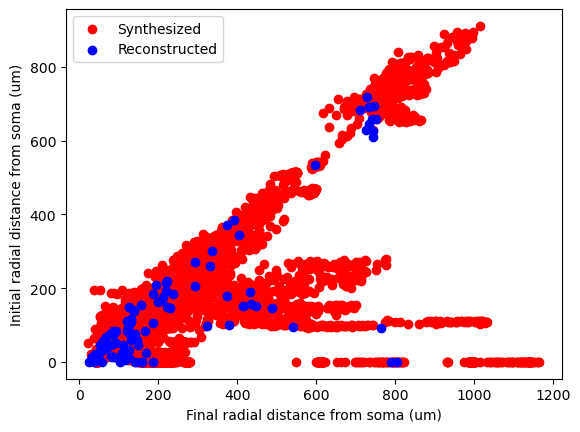

In [6]:
import tmd
import matplotlib.pyplot as plt
import numpy as np


points_all = np.empty((0, 2))
for i in range(len(filenames)):
    neuron = tmd.io.load_neuron_from_morphio("data/bio612/" + filenames[i])
    points = tmd.methods.get_ph_neuron(neuron, feature="radial_distances")
    points_all = np.append(points_all, np.array(points), axis=0)

plt.scatter(points_all[:, 0], points_all[:, 1], c='red', label='Synthesized')
plt.xlabel('Final radial distance from soma (um)')
plt.ylabel('Initial radial distance from soma (um)')

neuron = tmd.io.load_neuron_from_morphio("data/neurons/C220197A-P2.h5")
points = tmd.methods.get_ph_neuron(neuron, feature="radial_distances")
points = np.array(points)
plt.scatter(points[:, 0], points[:, 1], c='blue', label='Reconstructed')
plt.legend()

In [7]:
import morphio
from neurom.core.morphology import Morphology
from neurom.core.population import Population
from neurom.io.utils import load_morphologies
from collections import defaultdict
import neurom as nm

# Neurite types of interest
NEURITES_ = (nm.NeuriteType.apical_dendrite,
             nm.NeuriteType.basal_dendrite)


# Features of interest
FEATURES = ('number_of_neurites', 
            'number_of_sections', 
            'section_term_lengths', 
            'number_of_bifurcations',
            'section_lengths',
            'section_tortuosity', 
            'section_radial_distances',
            'section_path_distances',
            'section_branch_orders', 
            'local_bifurcation_angles')

def load_neurite_features_pop(filepath):
    """Unpack relevant data into megadict."""
    stuff = defaultdict(lambda: defaultdict(list))
    morphs = nm.load_morphologies(filepath)
    # unpack data into arrays
    for t in NEURITES_:
        for feat in FEATURES:

            stuff[feat][str(t).split('.')[1]].extend(
                nm.get(feat, morphs, neurite_type=t)
            )
    return stuff



features_synth = load_neurite_features_pop(folder)
features_reco  = load_neurite_features_pop("data/neurons/C220197A-P2.h5")

/tmp/ipykernel_306665/2294443809.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[Text(0.5, 0, 'absolute values'), Text(0, 0.5, '')]

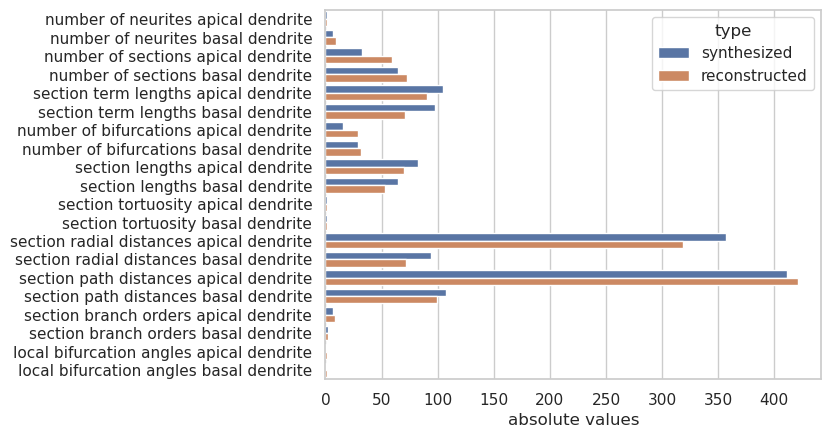

In [40]:
import pandas as pd 
import seaborn as sns

pd_synth = pd.DataFrame(features_synth)
pd_reco  = pd.DataFrame(features_reco)

pd_synth_mean = pd_synth
pd_reco_mean = pd_reco
for row in list(pd_synth.index):
    for col in  list(pd_synth):
        pd_synth_mean.loc[row, col] = np.mean(pd_synth.loc[row, col])
        pd_reco_mean.loc[row, col] = np.mean(pd_reco.loc[row, col])

pd_synth_mean = pd_synth_mean.unstack()
pd_synth_mean.index = pd_synth_mean.index.map('_'.join)
pd_synth_mean.index = pd_synth_mean.index.str.split('_')
pd_synth_mean.index = pd_synth_mean.index.map(' '.join)
pd_synth_mean = pd.DataFrame(pd_synth_mean)
pd_synth_mean['type'] = ['synthesized'] * len(pd_synth_mean.index)

pd_reco_mean = pd_reco_mean.unstack()
pd_reco_mean.index = pd_reco_mean.index.map('_'.join)
pd_reco_mean.index = pd_reco_mean.index.str.split('_')
pd_reco_mean.index = pd_reco_mean.index.map(' '.join)
pd_reco_mean = pd.DataFrame(pd_reco_mean)
pd_reco_mean['type']  = ['reconstructed'] * len(pd_reco_mean.index)

pd_all = pd_synth_mean
pd_all = pd_all.append(pd_reco_mean)

pd_all = pd_all.reset_index()

ax = sns.barplot(data=pd_all, x=0, y='index', hue='type')
ax.set(xlabel='absolute values', ylabel='')

In [102]:
pd_all

,index,signal,type,neurite
0,number of neurites,1.000000,synthesized,apical
0,number of neurites,1.000000,synthesized,apical
0,number of neurites,1.000000,synthesized,apical
0,number of neurites,1.000000,synthesized,apical
0,number of neurites,1.000000,synthesized,apical
...,...,...,...,...
19,local bifurcation angles,1.537959,reconstructed,basal
19,local bifurcation angles,0.822624,reconstructed,basal
19,local bifurcation angles,1.165648,reconstructed,basal
19,local bifurcation angles,1.752827,reconstructed,basal


/tmp/ipykernel_306665/430148055.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_306665/430148055.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Apical dendrites')

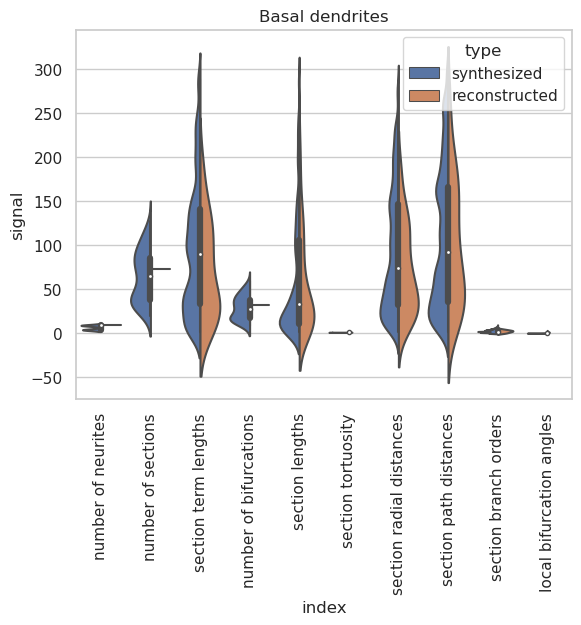

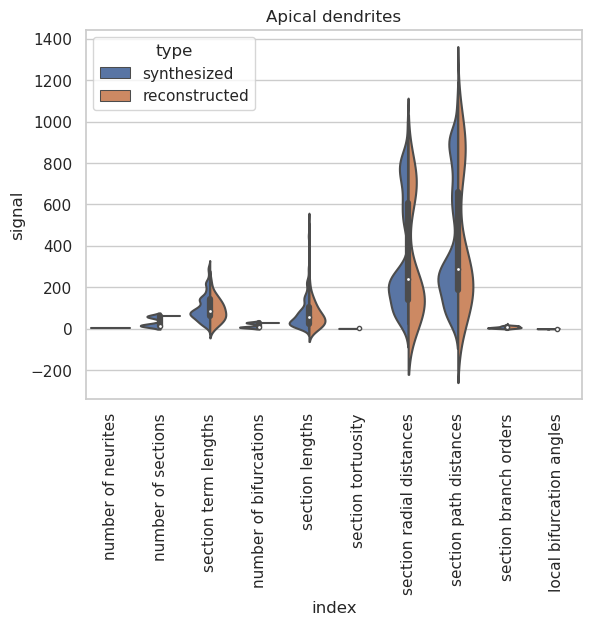

In [111]:
import pandas as pd 
import seaborn as sns

pd_synth = pd.DataFrame(features_synth)
pd_reco  = pd.DataFrame(features_reco)

pd_synth = pd_synth.unstack()
pd_synth.index = pd_synth.index.map('_'.join)
pd_synth = pd.DataFrame(pd_synth)
pd_synth = pd_synth.reset_index()
pd_synth['type'] = ['synthesized'] * len(pd_synth.index)
pd_synth = pd_synth.rename({0: "signal"}, axis='columns')
pd_synth = pd_synth.explode('signal')
pd_synth['signal'] = pd_synth['signal'].astype(float)

pd_reco = pd_reco.unstack()
pd_reco.index = pd_reco.index.map('_'.join)
pd_reco = pd.DataFrame(pd_reco)
pd_reco = pd_reco.reset_index()
pd_reco['type'] = ['reconstructed'] * len(pd_reco.index)
pd_reco = pd_reco.rename({0: "signal"}, axis='columns')
pd_reco = pd_reco.explode('signal')
pd_reco['signal'] = pd_reco['signal'].astype(float)

pd_all = pd_synth
pd_all = pd_all.append(pd_reco)
pd_all['index'].str.contains('apical')
pd_all['neurite'] = ['basal'] * len(pd_all.index)
pd_all['neurite'][pd_all['index'].str.contains('apical')] = ['apical'] * len(pd_all['neurite'][pd_all['index'].str.contains('apical')])
pd_all['index'] = pd_all['index'].str.split('_')
pd_all['index']
pd_all['index'] = pd_all['index'].map(' '.join)

a = pd_all['index'].str.split().values
a = list(a)
for i in range(len(a)):
    a[i] = a[i][:-2]
    a[i] = ' '.join(a[i])
pd_all['index'] = a

sns.set(style = 'whitegrid')
sns.violinplot(data=pd_all[pd_all['neurite']=='basal'], x='index', y='signal', hue="type", split=True)
plt.xticks(rotation=90)
plt.title('Basal dendrites')

plt.figure()
sns.violinplot(data=pd_all[pd_all['neurite']=='apical'], x='index', y='signal', hue="type", split=True)
plt.xticks(rotation=90)
plt.title('Apical dendrites')


In [7]:
feat_list = ['number_of_neurites', 
            'number_of_sections', 
            'section_term_lengths', 
            'number_of_bifurcations',
            'section_lengths',
            'section_tortuosity', 
            'section_radial_distances',
            'section_path_distances',
            'section_branch_orders', 
            'local_bifurcation_angles']
            
def get_features_medians(object1, object2, flist=feat_list, neurite_type=nm.BASAL_DENDRITE):
    """Computes features from module mod"""
    collect_all = []

    for feat in flist:
        feature_pop = [np.median(nm.get(feat, obj, neurite_type=neurite_type)) for obj in object1]
        feature_neu = [np.median(nm.get(feat, obj, neurite_type=neurite_type)) for obj in object2]
        collect_all.append([feature_pop, feature_neu])

    return collect_all

def get_features_std(object, flist=feat_list, neurite_type=nm.BASAL_DENDRITE):
    """Computes features from module mod"""
    collect_all = []

    for feat in flist:
        feature_pop = [np.std(nm.get(feat, obj, neurite_type=neurite_type)) for obj in object]
        collect_all.append(feature_pop)

    return collect_all

def get_features(object1, object2, flist=feat_list, neurite_type=nm.BASAL_DENDRITE):
    """Computes features from module mod"""
    collect_all = []

    for feat in flist:
        feature_pop = nm.get(feat, object1, neurite_type=neurite_type)
        feature_neu = nm.get(feat, object2, neurite_type=neurite_type)

        collect_all.append([feature_pop, feature_neu])

    return collect_all
    
morphs     = nm.load_morphologies(folder)
morph_reco = nm.load_morphologies("data/neurons/C220197A-P2.h5")
med             = get_features_medians(morphs, morph_reco, flist=feat_list, neurite_type=nm.BASAL_DENDRITE)
std             = get_features_std(morph_reco, flist=feat_list, neurite_type=nm.BASAL_DENDRITE)
features_basal  = get_features(morphs, morph_reco, flist=feat_list, neurite_type=nm.BASAL_DENDRITE)
features_apical = get_features(morphs, morph_reco, flist=feat_list, neurite_type=nm.APICAL_DENDRITE)

In [48]:
features_synth.keys(), features_synth['number_of_neurites']['basal_dendrite']

dict_keys(['number_of_neurites', 'number_of_sections', 'section_term_lengths', 'number_of_bifurcations', 'section_lengths', 'section_tortuosity', 'section_radial_distances', 'section_path_distances', 'section_branch_orders', 'local_bifurcation_angles'])

In [112]:
pd_synth[0].values[0]

1

In [65]:
# Neurite types of interest
NEURITES_ = (nm.NeuriteType.apical_dendrite,
             nm.NeuriteType.basal_dendrite)


# Features of interest
FEATURES = ('segment_lengths',
            'section_lengths',
            'section_path_distances',
            'section_radial_distances',
            'trunk_origin_radii')


def load_neurite_features(filepath):
    """Unpack relevant data into megadict."""
    stuff = defaultdict(lambda: defaultdict(list))
    morphs = nm.load_morphologies(filepath)
    # unpack data into arrays
    for m in morphs:
        for t in NEURITES_:
            for feat in FEATURES:
                stuff[feat][str(t).split('.')[1]].extend(
                    nm.get(feat, m, neurite_type=t)
                )
    return stuff

<bound method get_bounding_box of <tmd.Neuron.Neuron.Neuron object at 0x7f18ee0fe770>>

### Run the example synthesize_single_neuron.py and plot the result

In [3]:
%run synthesize_single_neuron.py

morph = load_morphology("results_single_neuron/generated_cell.swc")
_ = plotly_impl.plot_morph3d(morph, inline=True)

JSONDecodeError: Expecting ',' delimiter: line 339 column 1 (char 8011)

RawDataError: File: results_single_neuron/generated_cell.swc does not exist.

### Run the example synthesize_neurons.py and plot the result

In [ ]:
%run synthesize_neurons.py

for i in range(10):
    morph = load_morphology(f"results_neurons/generated_cell_{i}.swc")
    _ = plotly_impl.plot_morph3d(morph, inline=True)

### Run the example synthesize_neuron_with_diameters.py and plot the result

In [ ]:
%run synthesize_neuron_with_diameters.py

morph = load_morphology("results_neuron_with_diameters/generated_cell.swc")
_ = plotly_impl.plot_morph3d(morph, inline=True)

### Run the example synthesize_neuron_external_diameter.py and plot the result

In [ ]:
%run synthesize_neuron_external_diameter.py

morph = load_morphology("results_neuron_external_diameter/generated_cell.swc")
_ = plotly_impl.plot_morph3d(morph, inline=True)